In [1]:
pip install transformers torch numpy gudhi -q

Note: you may need to restart the kernel to use updated packages.


Beware, I am not a competent linguist...

In [2]:
text = ["In the realm of linguistics, it is crucial to foster a deep understanding of language structures and their interconnections. This understanding is not simply about memorizing vocabulary or grammar rules, but delving into the intricate details of phonetics, semantics, and syntax. However, the common elements that we often focus on, such as morphemes, phonemes, and syntax rules, are merely the tip of the iceberg. Beneath the surface, there lies a vast field of cognitive, social, and historical factors that play significant roles in shaping a language. Grasping these underlying influences is what sets apart a competent linguist from a casual language learner."]

In [3]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel


def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
    model = AutoModel.from_pretrained("xlm-roberta-large") 


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 157, 64])
tensor([[[ 0.0071, -0.0150, -0.0101,  ..., -0.0168, -0.0098,  0.0060],
         [ 0.0115, -0.0032, -0.0297,  ...,  0.0008,  0.0051, -0.0405],
         [ 0.0092,  0.0022, -0.0131,  ..., -0.0147, -0.0263,  0.0235],
         ...,
         [-0.0102, -0.0250, -0.0136,  ..., -0.0074, -0.0021, -0.0116],
         [ 0.0105, -0.0189, -0.0179,  ..., -0.0143, -0.0057,  0.0069],
         [-0.0452, -0.0064,  0.0127,  ...,  0.0085, -0.0022,  0.0116]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


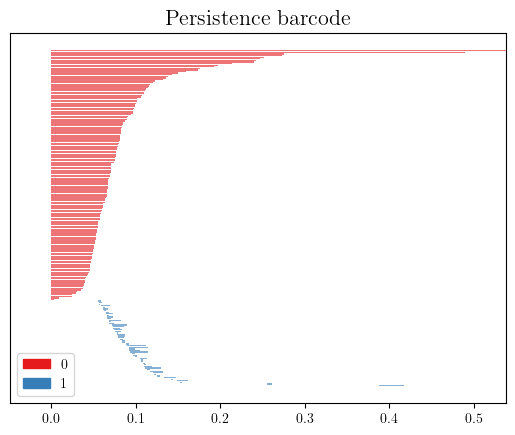

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [5]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=3.0):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: <s>, ▁In, ▁the, ▁real, m, ▁of, ▁linguis, tics, ,, ▁it, ▁is, ▁crucial, ▁to, ▁fost, er, ▁a, ▁deep, ▁understanding, ▁of, ▁language, ▁structure, s, ▁and, ▁their, ▁inter, connect, ions, ., ▁This, ▁understanding, ▁is, ▁not, ▁simply, ▁about, ▁memori, zing, ▁vocabula, ry, ▁or, ▁gramm, ar, ▁rules, ,, ▁but, ▁del, ving, ▁into, ▁the, ▁in, trica, te, ▁details, ▁of, ▁phone, tics, ,, ▁sem, antic, s, ,, ▁and, ▁syn, tax, ., ▁However, ,, ▁the, ▁common, ▁elements, ▁that, ▁we, ▁often, ▁focus, ▁on, ,, ▁such, ▁as, ▁mor, phe, mes, ,, ▁phone, mes, ,, ▁and, ▁syn, tax, ▁rules, ,, ▁are, ▁mere, ly, ▁the, ▁tip, ▁of, ▁the, ▁, ice, berg, ., ▁Bene, ath, ▁the, ▁surface, ,, ▁there, ▁li, es, ▁a, ▁vast, ▁field, ▁of, ▁cognitive, ,, ▁social, ,, ▁and, ▁historical, ▁factors, ▁that, ▁play, ▁significant, ▁role, s, ▁in, ▁sha, ping, ▁a, ▁language, ., ▁Gra, s, ping, ▁these, ▁under, ly, ing, ▁influence, s, ▁is, ▁what, ▁set, s, ▁apart, ▁a, ▁, competent, ▁linguis, t, ▁from, ▁a, ▁casual, ▁language, ▁le

Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.13552635 0.26038853 0.10326075 0.1078747  0.06912947
  0.12607147]
 [0.13552635 0.         0.36084773 0.1662913  0.04449061 0.17346508
  0.06601286]
 [0.26038853 0.36084773 0.         0.26591123 0.33846701 0.23111153
  0.36671751]
 [0.10326075 0.1662913  0.26591123 0.         0.1389687  0.07374736
  0.16173371]
 [0.1078747  0.04449061 0.33846701 0.1389687  0.         0.1400055
  0.055665  ]
 [0.06912947 0.17346508 0.23111153 0.07374736 0.1400055  0.
  0.16657021]
 [0.12607147 0.06601286 0.36671751 0.16173371 0.055665   0.16657021
  0.        ]]


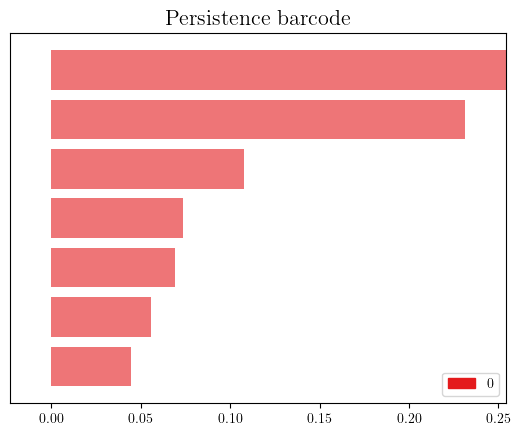

[(0, (0.0, inf)),
 (0, (0.0, 0.2311115270860177)),
 (0, (0.0, 0.10787470013140917)),
 (0, (0.0, 0.07374736435662728)),
 (0, (0.0, 0.06912947468888272)),
 (0, (0.0, 0.0556650045932026)),
 (0, (0.0, 0.044490614754122686))]

In [6]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "the tip of the iceberg")

In [7]:
text_2 = ["In the realm of deep learning, having a deep understanding of neural networks and their architectures is of paramount importance. It's not just about knowing how to code an algorithm, but also about comprehending how different layers in a network interact and learning to interpret the output. Yet, the algorithms and architectures we often discuss, like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs), are just the tip of the iceberg. Hidden below the surface are complex concepts like backpropagation, weight initialization, and optimization techniques, which truly drive the functionality of these networks. Mastering these intricacies is what differentiates an expert in the field from an amateur coder."]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.12227714 0.26465006 0.06940242 0.07993846 0.11481511
  0.11637901]
 [0.12227714 0.         0.34438362 0.15640352 0.06308265 0.17962221
  0.08816364]
 [0.26465006 0.34438362 0.         0.25754677 0.29858008 0.19171904
  0.35849537]
 [0.06940242 0.15640352 0.25754677 0.         0.11022776 0.13180873
  0.15491308]
 [0.07993846 0.06308265 0.29858008 0.11022776 0.         0.13247664
  0.08784776]
 [0.11481511 0.17962221 0.19171904 0.13180873 0.13247664 0.
  0.19449885]
 [0.11637901 0.08816364 0.35849537 0.15491308 0.08784776 0.19449885
  0.        ]]


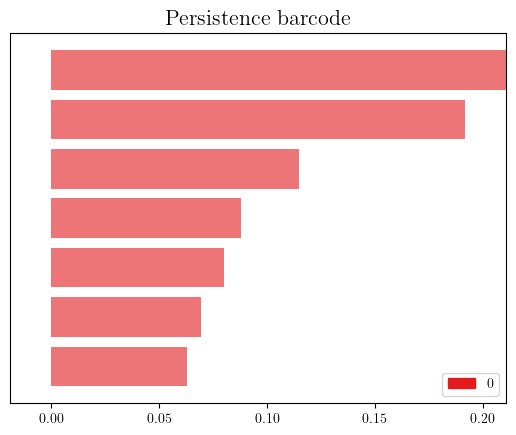

[(0, (0.0, inf)),
 (0, (0.0, 0.19171904429174208)),
 (0, (0.0, 0.114815114513929)),
 (0, (0.0, 0.08784776485621601)),
 (0, (0.0, 0.07993846073692952)),
 (0, (0.0, 0.0694024154075328)),
 (0, (0.0, 0.06308265087333154))]

In [8]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "the tip of the iceberg")

---

## English Persistent Homology Comparison

Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.13552635 0.26038853 0.10326075 0.1078747  0.06912947
  0.12607147]
 [0.13552635 0.         0.36084773 0.1662913  0.04449061 0.17346508
  0.06601286]
 [0.26038853 0.36084773 0.         0.26591123 0.33846701 0.23111153
  0.36671751]
 [0.10326075 0.1662913  0.26591123 0.         0.1389687  0.07374736
  0.16173371]
 [0.1078747  0.04449061 0.33846701 0.1389687  0.         0.1400055
  0.055665  ]
 [0.06912947 0.17346508 0.23111153 0.07374736 0.1400055  0.
  0.16657021]
 [0.12607147 0.06601286 0.36671751 0.16173371 0.055665   0.16657021
  0.        ]]


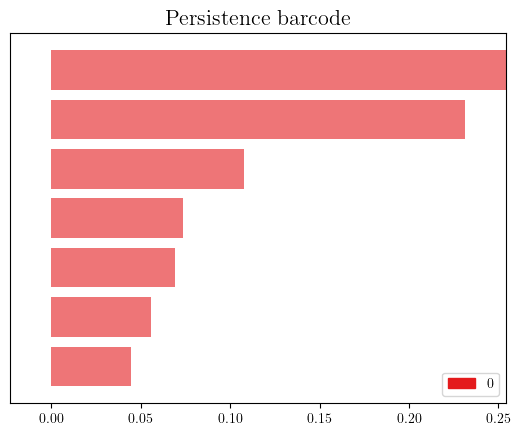

Tokens of the sub-collection: ['▁the', '▁tip', '▁of', '▁the', '▁', 'ice', 'berg']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.12227714 0.26465006 0.06940242 0.07993846 0.11481511
  0.11637901]
 [0.12227714 0.         0.34438362 0.15640352 0.06308265 0.17962221
  0.08816364]
 [0.26465006 0.34438362 0.         0.25754677 0.29858008 0.19171904
  0.35849537]
 [0.06940242 0.15640352 0.25754677 0.         0.11022776 0.13180873
  0.15491308]
 [0.07993846 0.06308265 0.29858008 0.11022776 0.         0.13247664
  0.08784776]
 [0.11481511 0.17962221 0.19171904 0.13180873 0.13247664 0.
  0.19449885]
 [0.11637901 0.08816364 0.35849537 0.15491308 0.08784776 0.19449885
  0.        ]]


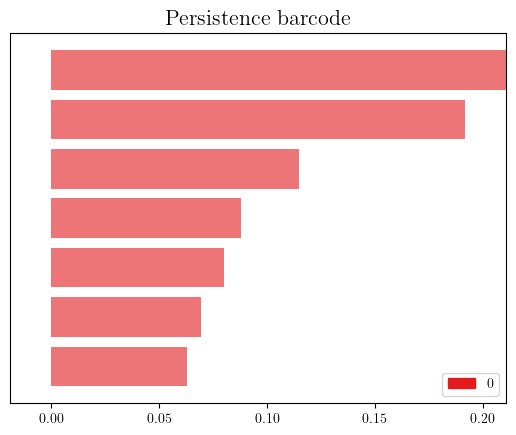

Bottleneck distance: 0.039392482794275624
Wasserstein distance: = 0.10


In [9]:
# from gudhi.wasserstein import wasserstein_distance 
# Could also be: 
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "the tip of the iceberg")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "the tip of the iceberg")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Yiddish Persistent Homology Comparison

In [32]:
text_3 = ["אין דער וועלט פון לינגוויסטיק, איז דער נעציק צו פאָסטערן אַ טיף פֿאַרשטייַנען פון שפּראַך סטרוקטורן און זייערע אינטערקאַנעקשאַנס. דאס פֿאַרשטייַנען איז ניט נאָר וועגן לערנען וואָקאַבולערי אָדער גראַמאַטיק רולז, אָבער אויך ערנטע די דעטאַלז פון פֿאָנעטיק, סעמאַנטיקס, און סינטאַקס. דאָך, די געוויינטלעך עלעמענטן אַז מיר פֿאָקוסירן אויף, ווי מאָרפֿעמען, פֿאָנעמען, און סינטאַקס רולז, זענען בלויז דער שפּיץ פון די ייסבערג. אונטער דער אויבערפֿלאַך, ליגן אַ וואַסט פעלד פון קאָגניטיוו, סאַציאַל, און היסטאָרישע פאַקטאָרן וואָס שפּילן וויכטיק ראָלז אין שייפֿינג אַ שפּראַך. גרייפֿן די אונטערלייגנדיקע אינפֿלוענסז איז וואָס שטעלט אַרויס אַ קאָמפּעטענט לינגוויסט פון אַ קאַזשועל שפּראַך לערנער."]

text_4 = ["אין די מעלוכע פון טיף לערנען, אַ טיף פארשטאנד פון נעוראַל נעטוואָרקס און זייער אַרקאַטעקטשערז איז פון העכסט וויכטיקייט. עס איז נישט בלויז צו וויסן ווי צו קאָד אַ אַלגערידאַם, אָבער אויך צו פֿאַרשטיין ווי פאַרשידענע לייַערס אין אַ נעץ ינטעראַקט און לערנען צו טייַטשן די רעזולטאַט. אָבער, די אַלגערידאַמז און אַרקאַטעקטשערז וואָס מיר אָפט דיסקוטירן, ווי קאָנוואָלוטיאָנאַל נעוראַל נעטוואָרקס (CNNs) אָדער ריקעראַנט נעוראַל נעטוואָרקס (RNNs), זענען נאָר דער שפּיץ פון די ייסבערג. פאַרבאָרגן אונטער די ייבערפלאַך זענען קאָמפּלעקס קאַנסעפּס ווי באַקפּראָפּאַגאַטיאָן, וואָג יניטיאַליזיישאַן און אַפּטאַמאַזיישאַן טעקניקס, וואָס טאַקע פירן די פאַנגקשאַנאַליטי פון די נעטוואָרקס. מאַסטערינג די ינטראַקאַסיז איז וואָס דיפערענשיייץ אַ מומחה אין דעם פעלד פון אַ ליבהאָבער קאָדער."]

In [33]:
context_3 = [compute_output(t, layer, head) for t in text_3]

context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁דער', '▁שפּ', 'יץ', '▁פון', '▁די', '▁', 'ייס', 'בער', 'ג']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.24766292 0.36338857 1.47439517 0.34838002 0.29754043
  0.28854904 1.14396342 0.32157627]
 [0.24766292 0.         0.16446127 1.53228947 0.15047131 0.24912672
  0.11620377 1.20269662 0.14019531]
 [0.36338857 0.16446127 0.         1.63575853 0.08885303 0.3431425
  0.11361469 1.31003952 0.15431674]
 [1.47439517 1.53228947 1.63575853 0.         1.59480299 1.31165099
  1.57152276 0.47064077 1.50602063]
 [0.34838002 0.15047131 0.08885303 1.59480299 0.         0.30006603
  0.10633443 1.27178335 0.12512236]
 [0.29754043 0.24912672 0.3431425  1.31165099 0.30006603 0.
  0.27226492 0.98784398 0.20884514]
 [0.28854904 0.11620377 0.11361469 1.57152276 0.10633443 0.27226492
  0.         1.23388785 0.10696037]
 [1.14396342 1.20269662 1.31003952 0.47064077 1.27178335 0.98784398
  1.23388785 0.         1.17670842]
 [0.32157627 0.14019531 0.15431674 1.5060206

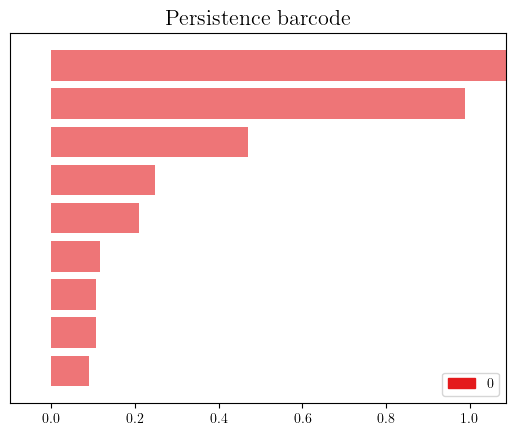

Tokens of the sub-collection: ['▁דער', '▁שפּ', 'יץ', '▁פון', '▁די', '▁', 'ייס', 'בער', 'ג']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.17478122 0.29823836 1.37936784 0.23177346 0.2752977
  0.22243818 0.6839391  0.34041241]
 [0.17478122 0.         0.14507253 1.42525277 0.09130074 0.24888569
  0.08983483 0.69095015 0.17793234]
 [0.29823836 0.14507253 0.         1.50503174 0.1143788  0.33385189
  0.12189592 0.76561116 0.09676325]
 [1.37936784 1.42525277 1.50503174 0.         1.44052622 1.18571584
  1.44129373 0.88442632 1.48335094]
 [0.23177346 0.09130074 0.1143788  1.44052622 0.         0.26072001
  0.09556268 0.7253972  0.12993303]
 [0.2752977  0.24888569 0.33385189 1.18571584 0.26072001 0.
  0.27074958 0.50562796 0.31864319]
 [0.22243818 0.08983483 0.12189592 1.44129373 0.09556268 0.27074958
  0.         0.69094598 0.15674718]
 [0.6839391  0.69095015 0.76561116 0.88442632 0.7253972  0.50562796
  0.69094598 0.         0.75250526]
 [0.34041241 0.17793234 0.09676325 1.4833509

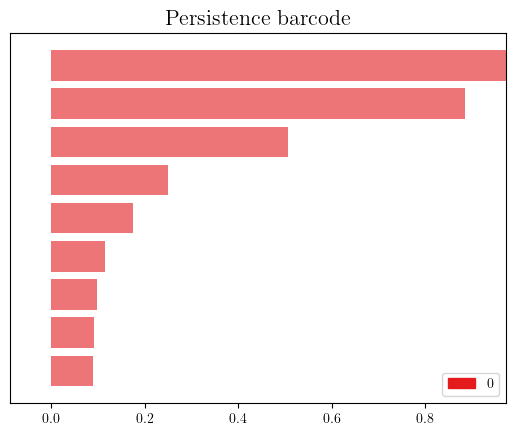

Bottleneck distance: 0.10341765695348737
Wasserstein distance: = 0.20


In [34]:
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "דער שפּיץ פון די ייסבערג")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "דער שפּיץ פון די ייסבערג")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Hebrew Persistent Homology Comparison



In [13]:
text_5 = ["בעולם של הבלשנות, ההבנה העמוקה של מבני שפה והיחסים שביניהם היא המרכז. ההבנה הזו אינה מתמקדת רק בלמידת אוצר מילים או כללי דקדוק, אלא גם בחקירת פרטי הפונטיקה, הסמנטיקה, והתחביר. אך, הרכיבים הרגילים שאנו מתמקדים בהם, כמו מורפמות, פונמות, וכללים תחביריים, הם רק קצה הקרחון. מתחת לפני השטח, נמצאת שדה עצום של גורמים קוגניטיביים, חברתיים, והיסטוריים שמשחקים תפקידים חשובים בעיצוב שפה. חידוד ההבנה של ההשפעות המשניות האלה הוא מה שמבדיל בין בלשן מיומן ללומד שפה חסר ניסיון."]

text_6 = ["בעולם של הלמידה העמוקה, ההבנה העמוקה של רשתות נוירונים והמבנים שלהם היא מרכזית. זה לא רק על ידע איך לכתוב אלגוריתם, אלא גם על הבנת איך שונות תאים ברשת מאפשרות לה ללמוד ולפרשת את התוצאות. אך, האלגוריתמים והמבנים שאנו מתמקדים בהם, כמו רשתות נוירונים המקוננות או רשתות נוירונים חוזרות נשנות, הם רק קצה הקרחון. מתחת לפני השטח, נמצאים מנגנונים מורכבים כמו התפשטות נגזרת, איניציאציה של משקלים, וטכניקות אופטימיזציה, שהם מה שמניעים את הרשתות. השליטה בפרטים הדקים האלה היא מה שמבחינה בין מומחה בתחום למתכנת שאין לו ניסיון."]

In [14]:
context_5 = [compute_output(t, layer, head) for t in text_5]

context_6 = [compute_output(t, layer, head) for t in text_6]


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁ק', 'צה', '▁הקר', 'ח', 'ון']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.24665141 0.2302752  0.20997432 0.54472245]
 [0.24665141 0.         0.18055645 0.12862975 0.40164975]
 [0.2302752  0.18055645 0.         0.19686015 0.49060783]
 [0.20997432 0.12862975 0.19686015 0.         0.42686758]
 [0.54472245 0.40164975 0.49060783 0.42686758 0.        ]]


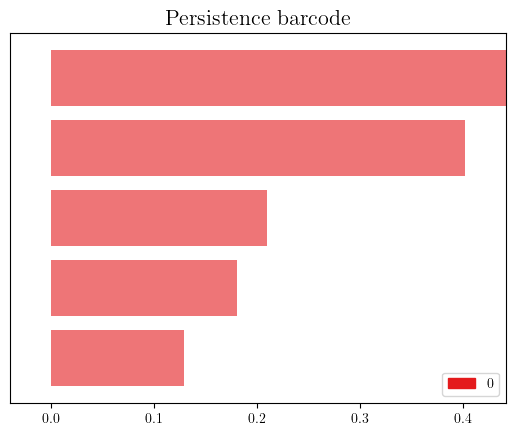

Tokens of the sub-collection: ['▁ק', 'צה', '▁הקר', 'ח', 'ון']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.28150469 0.3027373  0.25590264 0.55717074]
 [0.28150469 0.         0.13851365 0.13544996 0.32994942]
 [0.3027373  0.13851365 0.         0.19059364 0.33858596]
 [0.25590264 0.13544996 0.19059364 0.         0.37789914]
 [0.55717074 0.32994942 0.33858596 0.37789914 0.        ]]


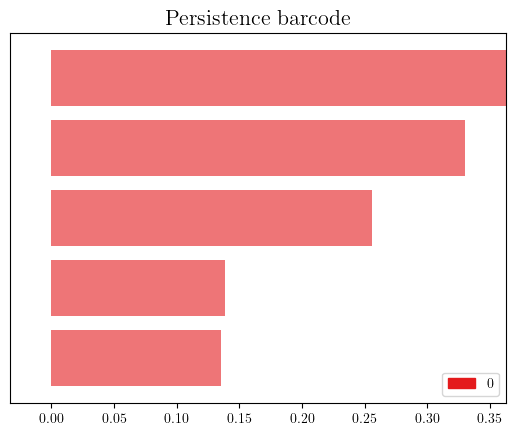

Bottleneck distance: 0.07170033083132515
Wasserstein distance: = 0.17


In [15]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_5[0], text_5[0], "קצה הקרחון")
persistent_homology_2 = compute_phrase_distances_and_homology(context_6[0], text_6[0], "קצה הקרחון")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Russian Persistent Homology Comparison

In [16]:
text_7 = ["В мире лингвистики глубокое понимание структур языка и их взаимосвязей является ключевым. Это понимание не ограничивается изучением словарного запаса или грамматических правил, но также включает изучение деталей фонетики, семантики и синтаксиса. Однако обычные компоненты, на которые мы обычно сосредотачиваемся, такие как морфемы, фонемы и грамматические правила, это лишь вершина айсберга. Под поверхностью находится огромное поле когнитивных, социальных и исторических факторов, которые играют важную роль в формировании языка. Уточнение понимания этих второстепенных влияний - то, что отличает опытного лингвиста от неопытного изучающего язык."]

text_8 = ["В мире глубокого обучения глубокое понимание нейронных сетей и их структур является центральным. Это не только о том, как написать алгоритм, но и о том, как различия между клетками в сети позволяют ей учиться и интерпретировать результаты. Однако алгоритмы и структуры, на которые мы обычно сосредотачиваемся, такие как сверточные нейронные сети (CNNs) или рекуррентные нейронные сети (RNNs), это лишь вершина айсберга. Под поверхностью находятся сложные механизмы, такие как распространение ошибок, инициализация весов и оптимизационные техники, которые в действительности двигают сети. Овладение этими тонкими деталями - то, что отличает эксперта в этой области от неопытного программиста."]

In [17]:
context_7 = [compute_output(t, layer, head) for t in text_7]

context_8 = [compute_output(t, layer, head) for t in text_8]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁вершин', 'а', '▁ай', 'с', 'берг', 'а']
Distance matrix: (6, 6)
Distance matrix: [[0.         0.04896919 0.21345799 0.35746105 0.05574635 0.15235619]
 [0.04896919 0.         0.19055361 0.33988301 0.08048636 0.14317186]
 [0.21345799 0.19055361 0.         0.36565984 0.24282188 0.21826082]
 [0.35746105 0.33988301 0.36565984 0.         0.37064019 0.43369837]
 [0.05574635 0.08048636 0.24282188 0.37064019 0.         0.17584009]
 [0.15235619 0.14317186 0.21826082 0.43369837 0.17584009 0.        ]]


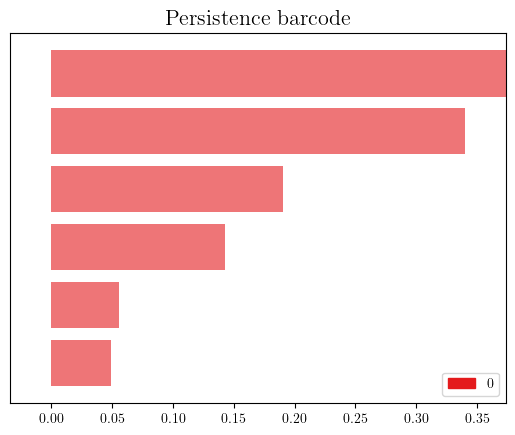

Tokens of the sub-collection: ['▁вершин', 'а', '▁ай', 'с', 'берг', 'а']
Distance matrix: (6, 6)
Distance matrix: [[0.         0.07830523 0.15008485 0.26618933 0.05805034 0.15288836]
 [0.07830523 0.         0.10128515 0.24974562 0.1019253  0.15149467]
 [0.15008485 0.10128515 0.         0.27908233 0.16647004 0.17397077]
 [0.26618933 0.24974562 0.27908233 0.         0.27308547 0.35310256]
 [0.05805034 0.1019253  0.16647004 0.27308547 0.         0.1785002 ]
 [0.15288836 0.15149467 0.17397077 0.35310256 0.1785002  0.        ]]


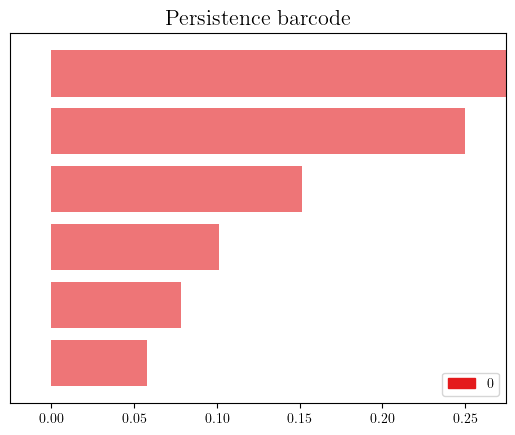

Bottleneck distance: 0.0901373847109207
Wasserstein distance: = 0.20


In [18]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_7[0], text_7[0], "вершина айсберга")
persistent_homology_2 = compute_phrase_distances_and_homology(context_8[0], text_8[0], "вершина айсберга")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## German Persistent Homology Comparison

In [19]:
text_9 = ["In der Welt der Linguistik ist ein tiefes Verständnis für Sprachstrukturen und ihre Beziehungen zentral. Dieses Verständnis beschränkt sich nicht nur auf das Erlernen von Vokabeln oder Grammatikregeln, sondern beinhaltet auch die Untersuchung von Details in Phonologie, Semantik und Syntax. Doch die üblichen Komponenten, auf die wir uns konzentrieren, wie Morpheme, Phoneme und Syntaxregeln, sind nur die Spitze des Eisbergs. Unter der Oberfläche liegt ein weites Feld kognitiver, sozialer und historischer Faktoren, die eine wichtige Rolle bei der Formung einer Sprache spielen. Das Verfeinern des Verständnisses dieser sekundären Einflüsse ist es, was einen versierten Linguisten von einem unerfahrenen Sprachlerner unterscheidet."]

text_10 = ["In der Welt des Deep Learning ist ein tiefes Verständnis für neuronale Netzwerke und ihre Strukturen zentral. Es geht nicht nur darum zu wissen, wie man einen Algorithmus schreibt, sondern auch zu verstehen, wie Unterschiede zwischen den Zellen im Netzwerk es ihr ermöglichen, zu lernen und Ergebnisse zu interpretieren. Aber die Algorithmen und Strukturen, auf die wir uns konzentrieren, wie Convolutional Neural Networks (CNNs) oder Recurrent Neural Networks (RNNs), sind nur die Spitze des Eisbergs. Unter der Oberfläche befinden sich komplexe Mechanismen wie Backpropagation, Gewichtsinitialisierung und Optimierungstechniken, die tatsächlich die Netzwerke antreiben. Die Beherrschung dieser feinen Details ist es, was einen Experten auf diesem Gebiet von einem unerfahrenen Programmierer unterscheidet."]

In [20]:
context_9 = [compute_output(t, layer, head) for t in text_9]

context_10 = [compute_output(t, layer, head) for t in text_10]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁die', '▁Spitze', '▁des', '▁Eis', 'bergs']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.12342932 0.12239395 0.14852223 0.26922144]
 [0.12342932 0.         0.16305342 0.08977922 0.20295832]
 [0.12239395 0.16305342 0.         0.13093655 0.33441025]
 [0.14852223 0.08977922 0.13093655 0.         0.25157283]
 [0.26922144 0.20295832 0.33441025 0.25157283 0.        ]]


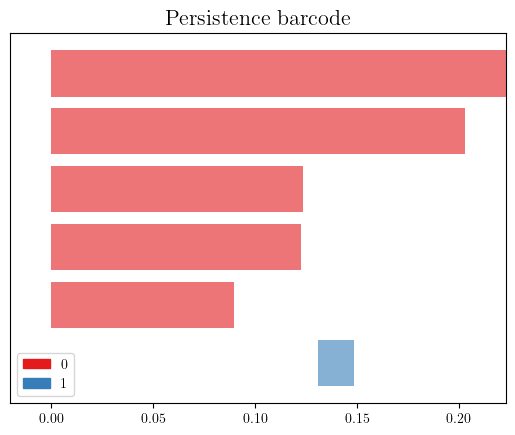

Tokens of the sub-collection: ['▁die', '▁Spitze', '▁des', '▁Eis', 'bergs']
Distance matrix: (5, 5)
Distance matrix: [[0.         0.12277545 0.13544431 0.15104017 0.32353836]
 [0.12277545 0.         0.13915664 0.05824637 0.28333151]
 [0.13544431 0.13915664 0.         0.12851485 0.37695455]
 [0.15104017 0.05824637 0.12851485 0.         0.31791838]
 [0.32353836 0.28333151 0.37695455 0.31791838 0.        ]]


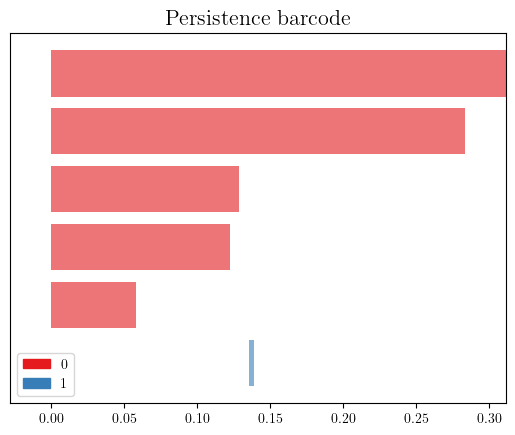

Bottleneck distance: 0.08037318815842931
Wasserstein distance: = 0.13


In [21]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_9[0], text_9[0], "die Spitze des Eisbergs")
persistent_homology_2 = compute_phrase_distances_and_homology(context_10[0], text_10[0], "die Spitze des Eisbergs")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## French Persistent Homology Comparison

In [22]:
text_11 = ["Dans le monde de la linguistique, une compréhension profonde des structures linguistiques et de leurs relations est centrale. Cette compréhension ne se limite pas à l'apprentissage du vocabulaire ou des règles grammaticales, mais inclut également l'étude des détails de la phonologie, de la sémantique et de la syntaxe. Cependant, les composants usuels sur lesquels nous nous concentrons, tels que les morphèmes, les phonèmes et les règles de syntaxe, ne sont que la pointe de l'iceberg. Sous la surface se trouve un vaste champ de facteurs cognitifs, sociaux et historiques qui jouent un rôle important dans la formation d'une langue. Affiner la compréhension de ces influences secondaires est ce qui distingue un linguiste expérimenté d'un apprenant de langue inexpérimenté."]

text_12 = ["Dans le monde de l'apprentissage profond, une compréhension profonde des réseaux de neurones et de leurs structures est centrale. Il ne s'agit pas seulement de savoir comment écrire un algorithme, mais aussi de comprendre comment les différences entre les cellules du réseau lui permettent d'apprendre et d'interpréter les résultats. Cependant, les algorithmes et les structures sur lesquels nous nous concentrons habituellement, tels que les réseaux de neurones convolutionnels (CNNs) ou les réseaux de neurones récurrents (RNNs), ne sont que la pointe de l'iceberg. Sous la surface se trouvent des mécanismes complexes tels que la rétropropagation, l'initialisation des poids et les techniques d'optimisation, qui sont en réalité ce qui anime les réseaux. Maîtriser ces détails subtils est ce qui distingue un expert dans ce domaine d'un programmeur inexpérimenté."]

In [23]:
context_11 = [compute_output(t, layer, head) for t in text_11]

context_12 = [compute_output(t, layer, head) for t in text_12]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁la', '▁point', 'e', '▁de', '▁l', "'", 'ice', 'berg']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.11856636 0.35627079 0.24381491 0.13438752 0.05565665
  0.12684304 0.08642485]
 [0.11856636 0.         0.26020267 0.29853011 0.22931624 0.16073182
  0.23108956 0.17307112]
 [0.35627079 0.26020267 0.         0.46659614 0.46108358 0.4013604
  0.46115964 0.40434081]
 [0.24381491 0.29853011 0.46659614 0.         0.20166628 0.24076562
  0.20904724 0.20770396]
 [0.13438752 0.22931624 0.46108358 0.20166628 0.         0.10584614
  0.07345003 0.0775072 ]
 [0.05565665 0.16073182 0.4013604  0.24076562 0.10584614 0.
  0.09120607 0.07978673]
 [0.12684304 0.23108956 0.46115964 0.20904724 0.07345003 0.09120607
  0.         0.09308319]
 [0.08642485 0.17307112 0.40434081 0.20770396 0.0775072  0.07978673
  0.09308319 0.        ]]


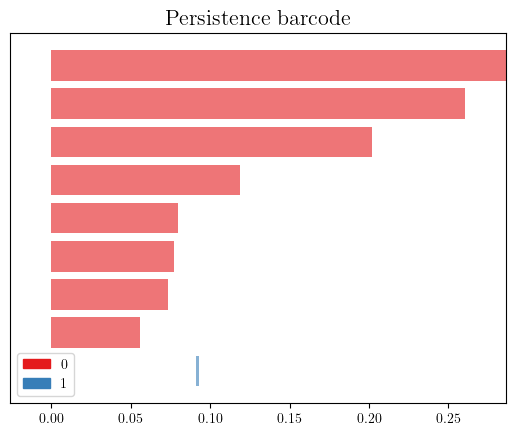

Tokens of the sub-collection: ['▁la', '▁point', 'e', '▁de', '▁l', "'", 'ice', 'berg']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.11498256 0.36528132 0.21656009 0.14826418 0.0565952
  0.1096635  0.08860294]
 [0.11498256 0.         0.27029531 0.27760128 0.24511464 0.16121079
  0.21182922 0.17875605]
 [0.36528132 0.27029531 0.         0.46364711 0.48125944 0.41214511
  0.45240625 0.41410319]
 [0.21656009 0.27760128 0.46364711 0.         0.16779609 0.21623664
  0.18215746 0.17438901]
 [0.14826418 0.24511464 0.48125944 0.16779609 0.         0.12036297
  0.0686052  0.08565447]
 [0.0565952  0.16121079 0.41214511 0.21623664 0.12036297 0.
  0.0705445  0.08214807]
 [0.1096635  0.21182922 0.45240625 0.18215746 0.0686052  0.0705445
  0.         0.06755254]
 [0.08860294 0.17875605 0.41410319 0.17438901 0.08565447 0.08214807
  0.06755254 0.        ]]


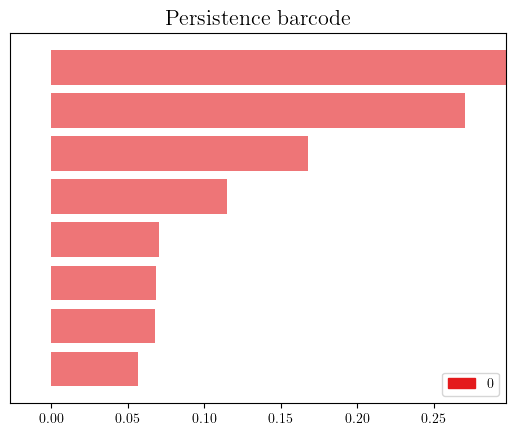

Bottleneck distance: 0.03387018218043242
Wasserstein distance: = 0.07


In [24]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_11[0], text_11[0], "la pointe de l'iceberg")
persistent_homology_2 = compute_phrase_distances_and_homology(context_12[0], text_12[0], "la pointe de l'iceberg")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

##  Bengali Persistent Homology Comparison

In [25]:
text_13 = ["ভাষাবিজ্ঞানের জগতে ভাষার গঠনমূলগুলি এবং তাদের মধ্যে সম্পর্কের গভীর বোধ কেন্দ্রীয়। এই বোধ শুধু ভোকাবুলারি বা ব্যাকরণের নিয়ম শেখার সাথে সীমাবদ্ধ নয়, বরং ফোনেটিক্স, সেম্যান্টিক্স এবং সিনট্যাক্সের বিস্তারিত অধ্যয়নও অন্তর্ভুক্ত করে। তবে, আমরা যে সাধারণ উপাদানগুলিতে মনোনিবেশ করি, যেমন মর্ফেম, ফোনেম এবং ব্যাকরণের নিয়ম, তা শুধু আইসবার্গের শীর্ষ। পৃষ্ঠতলের নিচে সংজ্ঞানাত্মক, সামাজিক এবং ঐতিহাসিক কারকগুলির একটি বিশাল ক্ষেত্র রয়েছে, যা একটি ভাষার গঠনে গুরুত্বপূর্ণ ভূমিকা পালন করে। এই দ্বিতীয়কক্ষ প্রভাবগুলির বোধ নির্দিষ্ট করা হলেই একজন অভিজ্ঞ ভাষাবিজ্ঞানী এবং অঅভিজ্ঞ ভাষা শিক্ষার্থীর মধ্যে পার্থক্য তৈরি হয়।"]

text_14 = ["ডিপ লার্নিং-এর পৃথিবীতে নিউরাল নেটওয়ার্ক এবং তাদের গঠনের গভীর বোধ কেন্দ্রীয়। এটি শুধু একটি অ্যালগরিদম লিখতে জানার বিষয় নয়, বরং নেটওয়ার্কের সেলগুলিতে পার্থক্য তাকে শেখার এবং ফলাফল ব্যাখ্যা করার ক্ষমতা বুঝতে ও অভিজ্ঞতা অর্জন করার ক্ষেত্রে গুরুত্বপূর্ণ। তবে, আমরা যে অ্যালগরিদম এবং গঠনগুলিতে সাধারণত মনোনিবেশ করি, যেমন কনভলিউশনাল নিউরাল নেটওয়ার্ক (CNNs) বা রিকারেন্ট নিউরাল নেটওয়ার্ক (RNNs), সেগুলি শুধু আইসবার্গের শীর্ষ। পৃষ্ঠতলের নিচে জটিল মেকানিজমগুলি রয়েছে, যেমন ব্যাকপ্রোপাগেশন, ওজন আরম্ভিকীকরণ এবং অনুকূলন পদ্ধতিগুলি, যা প্রকৃতপক্ষে নেটওয়ার্কগুলিকে চালিত করে। এই সূক্ষ্ম বিস্তারিতগুলিরএই সূক্ষ্ম বিস্তারিতগুলির দক্ষতা অর্জন করা হলেই একজন অভিজ্ঞ প্রোগ্রামার এবং অঅভিজ্ঞ প্রোগ্রামারের মধ্যে পার্থক্য তৈরি হয়।"]

In [26]:
context_13 = [compute_output(t, layer, head) for t in text_13]

context_14 = [compute_output(t, layer, head) for t in text_14]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁আই', 'স', 'বার', '্', 'গ', 'ের', '▁শীর্ষ']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.37931658 0.38633001 0.35441097 0.39305708 0.3644893
  0.19951425]
 [0.37931658 0.         0.06186847 0.08268154 0.08066446 0.17128081
  0.26325346]
 [0.38633001 0.06186847 0.         0.07722729 0.06210683 0.17269345
  0.28135381]
 [0.35441097 0.08268154 0.07722729 0.         0.07776841 0.20823525
  0.24377111]
 [0.39305708 0.08066446 0.06210683 0.07776841 0.         0.18862301
  0.28498072]
 [0.3644893  0.17128081 0.17269345 0.20823525 0.18862301 0.
  0.26305372]
 [0.19951425 0.26325346 0.28135381 0.24377111 0.28498072 0.26305372
  0.        ]]


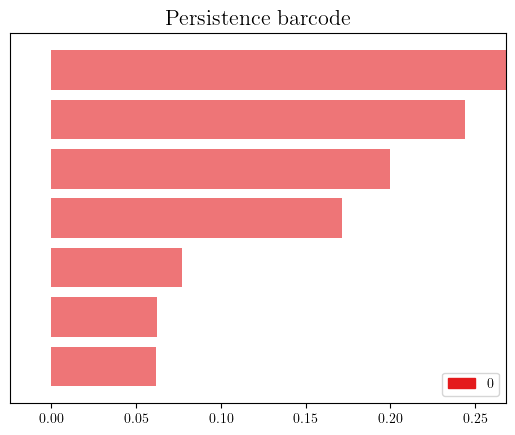

Tokens of the sub-collection: ['▁আই', 'স', 'বার', '্', 'গ', 'ের', '▁শীর্ষ']
Distance matrix: (7, 7)
Distance matrix: [[0.         0.35284473 0.37807938 0.32891579 0.39531248 0.29392102
  0.19065645]
 [0.35284473 0.         0.07701353 0.0738819  0.09986304 0.16772218
  0.31993416]
 [0.37807938 0.07701353 0.         0.07678298 0.06154397 0.16998099
  0.35727905]
 [0.32891579 0.0738819  0.07678298 0.         0.08919937 0.14624965
  0.29798604]
 [0.39531248 0.09986304 0.06154397 0.08919937 0.         0.19993423
  0.36411648]
 [0.29392102 0.16772218 0.16998099 0.14624965 0.19993423 0.
  0.27937519]
 [0.19065645 0.31993416 0.35727905 0.29798604 0.36411648 0.27937519
  0.        ]]


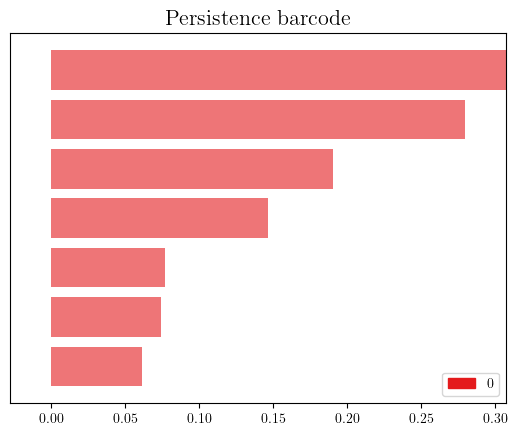

Bottleneck distance: 0.03560407992565773
Wasserstein distance: = 0.08


In [27]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_13[0], text_13[0], "আইসবার্গের শীর্ষ")
persistent_homology_2 = compute_phrase_distances_and_homology(context_14[0], text_14[0], "আইসবার্গের শীর্ষ")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")